In [1]:
import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())
try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
tensorflow: 2.20.0 | GPUs: 0


In [2]:
import os, sys, json, time
from pathlib import Path

ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from finance_lstm import read_prices 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 
import numpy as np

with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

def _require(cfg, keys):
    miss = set(keys) - set(cfg)
    if miss:
        raise KeyError(f"Missing config keys: {sorted(miss)}")

_require(C, ["ticker","start","end","interval","horizon","lookback","batch","epochs"])

TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
HORIZON  = int(C["horizon"])
LOOKBACK = int(C["lookback"])
BATCH    = int(C["batch"])
EPOCHS   = int(C["epochs"])
SEED     = int(C.get("seed", 42))

RESULTS_DIR = Path(C.get("results_dir", "../results"))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV   = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
TRAIN_CSV = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}.csv"


In [3]:
df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

In [4]:
# --- Spalten robust vereinheitlichen ---
# MultiIndex? -> Ebene mit den Feldnamen (Open/High/...) finden
if isinstance(df.columns, pd.MultiIndex):
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    # Falls die untere Ebene die typischen Felder enthält, nimm die:
    if {"open","high","low","close","adj close","volume"} & set(bot):
        df.columns = df.columns.get_level_values(1)
    # Falls die obere Ebene die Felder enthält (selten), nimm die:
    elif {"open","high","low","close","adj close","volume"} & set(top):
        df.columns = df.columns.get_level_values(0)
    else:
        # Fallback: Wenn die obere Ebene überall der Ticker ist (aapl...),
        # dann nimm die untere Ebene.
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Spaltennamen normalisieren
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", ""))

# Wenn nur adjclose existiert, bau close daraus
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Index & Reihenfolge
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()].sort_index()

# Pflichtspalten prüfen (BEVOR du droppst):
required = {"open","high","low","close","volume"}
missing  = required - set(df.columns)
if missing:
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Numerik + NaNs raus
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=list(required), how="any")


In [5]:
# --- Quick sanity checks ---
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")
if df.index.has_duplicates:
    raise ValueError("Duplicate timestamps gefunden.")

print("Spalten final:", df.columns.tolist())
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2012-01-03 → 2025-08-29 | n = 3435


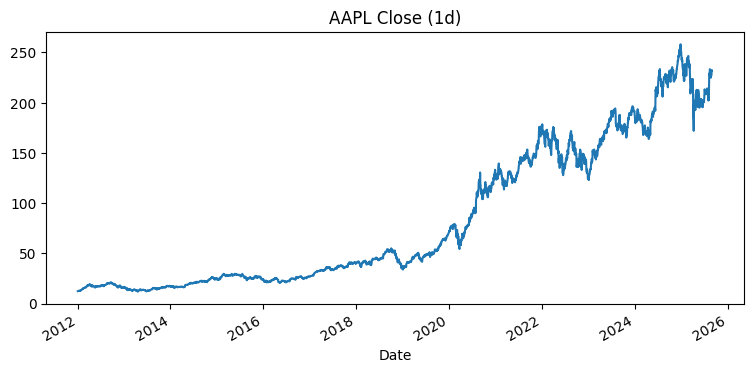

In [6]:
# --- Plot ---
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()

In [7]:
# --- CSV einfrieren (mit den standardisierten Namen) ---
os.makedirs("../data", exist_ok=True)
csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df.to_csv(csv_path)
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [8]:
# --- Manifest & Profiling ---
import hashlib, json

def _sha256_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

manifest = {
    "ticker": TICKER, "interval": INTERVAL, "start": START, "end": END,
    "rows": int(len(df)), "first_ts": str(df.index.min()), "last_ts": str(df.index.max()),
    "sha256": _sha256_file(csv_path),
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())
}
with open("../data/DATA_MANIFEST.json", "w") as f:
    json.dump(manifest, f, indent=2)

profiling = {
    "n": int(len(df)),
    "na_any": int(df.isna().any().any()),
    "close_min": float(df["close"].min()),
    "close_max": float(df["close"].max()),
    "logret_1d_mean": float(np.log(df["close"]).diff().dropna().mean()),
    "logret_1d_std": float(np.log(df["close"]).diff().dropna().std()),
}
with open("../data/profiling.json", "w") as f:
    json.dump(profiling, f, indent=2)

print("Manifest & Profiling geschrieben.")


Manifest & Profiling geschrieben.


In [9]:
import numpy as np, yaml, json
import pandas as pd
from finance_lstm import read_prices

In [10]:
FEATURESET = "v2"          # wir fahren v2
EPS_MODE   = "abs"         # absolute Schwelle
EPSILON    = 0.0005        # ~5 bp
HORIZON    = 5             # <-- Var B: ruhigeres Label

# Für die LogReg-Diagnose (Fensterende-Ausrichtung wie im Training):
with open(os.path.join(ROOT, "config.json"), "r") as f:
    _C = json.load(f)
LOOKBACK = int(_C.get("lookback", 60))

raw_csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df_raw = read_prices(raw_csv_path)
assert (df_raw["close"] > 0).all()

In [11]:
# -------- Featurebau (wie gehabt, v2) --------
def _rsi(close: pd.Series, n=14):
    r = close.diff().fillna(0.0)
    up  = r.clip(lower=0.0); dn = (-r).clip(lower=0.0)
    roll_up = up.rolling(n, min_periods=n).mean()
    roll_dn = dn.rolling(n, min_periods=n).mean()
    rs  = roll_up / (roll_dn + 1e-12)
    return 100.0 - (100.0 / (1.0 + rs))

def _macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()
    macd = ema_fast - ema_slow
    macd_sig = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    return macd, macd_sig, macd - macd_sig

def build_features_v2(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out["logret_1d"] = np.log(out["close"]).diff()
    out["logret_3d"] = out["logret_1d"].rolling(3, min_periods=3).sum()
    out["logret_5d"] = out["logret_1d"].rolling(5, min_periods=5).sum()
    out["realized_vol_10"] = out["logret_1d"].rolling(10, min_periods=10).std()
    sma20 = out["close"].rolling(20, min_periods=20).mean()
    std20 = out["close"].rolling(20, min_periods=20).std()
    out["bb_pos"] = (out["close"] - sma20) / (2.0*std20 + 1e-12)
    out["rsi_14"] = _rsi(out["close"], 14)
    macd, macd_sig, macd_diff = _macd(out["close"])
    out["macd"] = macd; out["macd_sig"] = macd_sig; out["macd_diff"] = macd_diff
    out["log_vol"] = np.log(out["volume"].replace(0, np.nan))
    roll_med = out["log_vol"].rolling(20, min_periods=20).median()
    roll_mad = out["log_vol"].rolling(20, min_periods=20).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    out["vol_z_20"] = (out["log_vol"] - roll_med) / (roll_mad + 1e-12)
    out["sma_diff"] = (out["close"].rolling(10, min_periods=10).mean() /
                       (out["close"].rolling(20, min_periods=20).mean() + 1e-12) - 1.0)
    return out

df_feat = build_features_v2(df_raw)

In [12]:
# -------- Labeling: Var A (abs. Kosten-Schwelle) --------
fut = np.log(df_feat["close"]).shift(-HORIZON)
cur = np.log(df_feat["close"])
fwd_logret = fut - cur

if EPS_MODE == "quantile":
    # falls wir später mal Q-Var testen wollen
    eps_val = float(fwd_logret.quantile(EPSILON if 0 < EPSILON < 1 else 0.55))
else:
    eps_val = float(EPSILON)  # <-- absolute log-return Schwelle

df_feat["target"] = (fwd_logret > eps_val).astype("int8")

# Aufräumen
df_clean = df_feat.dropna().sort_index()

In [13]:
# -------- Artefakte & saubere Namen --------
features_list = [
    "logret_1d","logret_3d","logret_5d",
    "realized_vol_10","bb_pos","rsi_14",
    "macd","macd_sig","macd_diff",
    "vol_z_20","sma_diff",
]
feature_meta = {
    "name": f"features_{FEATURESET}",
    "features": features_list,
    "label": {"horizon": HORIZON, "epsilon": eps_val, "mode": EPS_MODE},
    "note": "Nur rückwärtsgerichtete Rolling/EMA; keine Future-Leaks."
}
with open(f"../data/features_{FEATURESET}.yml", "w") as f:
    yaml.safe_dump(feature_meta, f)

In [14]:
# → dateiname mit H, Mode & Eps (reproduzierbar & kollisionsfrei)
eps_tag = f"{EPS_MODE}{str(EPSILON).replace('.','p')}"
train_csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}_{eps_tag}.csv"
df_clean.to_csv(train_csv_out, float_format="%.8f")

vc = df_clean["target"].value_counts().sort_index()
targets_summary = {
    "horizon": HORIZON, "epsilon": eps_val, "mode": EPS_MODE,
    "n": int(len(df_clean)),
    "class_counts": {int(k): int(v) for k, v in vc.items()},
    "pos_rate": float(vc.get(1,0)/vc.sum()) if vc.sum() else None,
}
with open("../data/targets_summary.json", "w") as f:
    json.dump(targets_summary, f, indent=2)

print("Train-CSV:", train_csv_out)
print("targets_summary:", targets_summary)
print(df_clean[["close","logret_1d","target"]].head())

Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h5_abs0p0005.csv
targets_summary: {'horizon': 5, 'epsilon': 0.0005, 'mode': 'abs', 'n': 3402, 'class_counts': {0: 1488, 1: 1914}, 'pos_rate': 0.562610229276896}
                close  logret_1d  target
Date                                    
2012-02-21  15.455858   0.025037       1
2012-02-22  15.401521  -0.003522       1
2012-02-23  15.502084   0.006508       1
2012-02-24  15.682812   0.011591       1
2012-02-27  15.783377   0.006392       1


In [15]:
# --- Diagnose 1: Label-Verteilung & Split ---
print("pos_rate overall:", round(df_clean["target"].mean(), 3), "| n:", len(df_clean))

# identischer 70/15/15-Split wie in Block 3/4
n = len(df_clean)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
train_idx = slice(0, n_train)
val_idx   = slice(n_train, n_train + n_val)
test_idx  = slice(n_train + n_val, n)

y_train = df_clean["target"].iloc[train_idx]
y_val   = df_clean["target"].iloc[val_idx]
y_test  = df_clean["target"].iloc[test_idx]
print("pos_rate train/val/test:",
      round(y_train.mean(),3), round(y_val.mean(),3), round(y_test.mean(),3))


pos_rate overall: 0.563 | n: 3402
pos_rate train/val/test: 0.577 0.535 0.524


In [16]:
# --- Diagnose 2: Baseline-LogReg (AUROC) ---
import yaml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Features v2 aus YAML lesen und auf vorhandene Spalten schneiden
with open(f"../data/features_{FEATURESET}.yml", "r") as f:
    meta = yaml.safe_load(f) or {}
FEATURES = [c for c in meta.get("features", []) if c in df_clean.columns]

X = df_clean[FEATURES].copy()
X_train = X.iloc[train_idx]; X_val = X.iloc[val_idx]; X_test = X.iloc[test_idx]

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=FEATURES)
X_val_s   = pd.DataFrame(scaler.transform(X_val),       index=X_val.index,   columns=FEATURES)
X_test_s  = pd.DataFrame(scaler.transform(X_test),      index=X_test.index,  columns=FEATURES)

# Fensterende an LOOKBACK ausrichten (wie das Netz)
Xtr_tail = X_train_s.iloc[LOOKBACK-1:]; ytr_tail = y_train.iloc[LOOKBACK-1:]
Xva_tail = X_val_s.iloc[LOOKBACK-1:];   yva_tail = y_val.iloc[LOOKBACK-1:]
Xte_tail = X_test_s.iloc[LOOKBACK-1:];  yte_tail = y_test.iloc[LOOKBACK-1:]

logit = LogisticRegression(max_iter=200)
logit.fit(Xtr_tail, ytr_tail)
va_auc = roc_auc_score(yva_tail, logit.predict_proba(Xva_tail)[:,1])
te_auc = roc_auc_score(yte_tail, logit.predict_proba(Xte_tail)[:,1])
print(f"[Baseline LogReg] AUROC val/test = {va_auc:.3f}/{te_auc:.3f}")


[Baseline LogReg] AUROC val/test = 0.592/0.445


In [17]:
# --- Checks & Vorschau ---
print("Spalten:", df_clean.columns.tolist())
print("Zeitraum:", df_clean.index.min().date(), "→", df_clean.index.max().date(), "| n =", len(df_clean))
print("\nVorschau:\n", df_clean[["close","logret_1d","target"]].head())
print("\nKlassenverteilung 0/1:", vc.to_dict(), "| Anteil 1:", round(vc.get(1,0)/vc.sum(), 3))

Spalten: ['open', 'high', 'low', 'close', 'volume', 'logret_1d', 'logret_3d', 'logret_5d', 'realized_vol_10', 'bb_pos', 'rsi_14', 'macd', 'macd_sig', 'macd_diff', 'log_vol', 'vol_z_20', 'sma_diff', 'target']
Zeitraum: 2012-02-21 → 2025-08-29 | n = 3402

Vorschau:
                 close  logret_1d  target
Date                                    
2012-02-21  15.455858   0.025037       1
2012-02-22  15.401521  -0.003522       1
2012-02-23  15.502084   0.006508       1
2012-02-24  15.682812   0.011591       1
2012-02-27  15.783377   0.006392       1

Klassenverteilung 0/1: {0: 1488, 1: 1914} | Anteil 1: 0.563


In [18]:
# --- Mini-Horizon-Demo (konsistent aus df_clean) ---
k = 100
if len(df_clean) <= max(k, HORIZON):
    raise ValueError("Zu wenige Zeilen für Mini-Demo. Wähle kleineren k oder prüfe HORIZON.")

i = df_clean.index[k]
pos_j = df_clean.index.get_loc(i) + HORIZON
if pos_j >= len(df_clean):
    raise IndexError("Index j liegt außerhalb des df_clean nach HORIZON-Shift.")
j = df_clean.index[pos_j]

print(f"\nHorizon-Check: {i.date()} -> {j.date()}")
print("close_i =", float(df_clean.loc[i, "close"]), " | close_j =", float(df_clean.loc[j, "close"]))
print("target_i =", int(df_clean.loc[i, "target"]))


Horizon-Check: 2012-07-13 -> 2012-07-20
close_i = 18.16126823425293  | close_j = 18.141162872314453
target_i = 0
